In [1]:
import cv2
import numpy as np
import yaml
import matplotlib.pyplot as plt

from Curves import curves
from LaneFilter import LaneFilter 
from BirdView import BirdView


In [2]:
image = cv2.imread('test_image.png')
#import image as array np

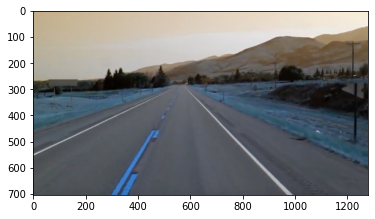

In [3]:
plt.imshow(image)
plt.show()

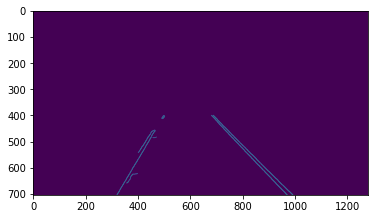

In [4]:
lanefilter = LaneFilter()
lane_image = np.copy(image)
filtered = lanefilter.toCanny(lane_image)
filtered = lanefilter.ROI(filtered)
plt.imshow(filtered)
plt.show()

In [5]:
#stream = file('calibration_data.yml', 'r')
#yaml.load(stream)

In [6]:
import pickle
calibration_data = pickle.load(open("calibration_data.p", "rb" ))

In [7]:
matrix = calibration_data['camera_matrix']
dist_coef = calibration_data['distortion_coefficient']

source_points = [(200, 700), (1100, 700), (790,400), (400, 400)]
dest_points = [(320, 704), (960, 704), (960, 0), (320, 0)]

birdview = BirdView(source_points, dest_points, matrix, dist_coef)

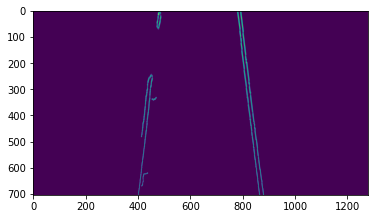

In [8]:
skyview = birdview.sky_view(filtered)
undistort = birdview.undistort(image)
plt.imshow(skyview)
plt.show()

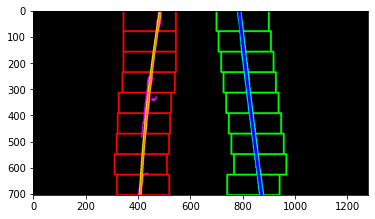

In [9]:
curves = curves(skyview, 9, 100, 50)
result = curves.Detect(skyview)
fig1 = plt.figure()
ax1 = fig1.subplots()
ax1.plot(result['curve_pointsx'], result['curve_pointsy'],color = 'r',alpha = 0.5, label = 'Polynomial fit')
plt.imshow(result['image'])

In [10]:
z = np.zeros_like(filtered)
filtered = np.dstack((z,z,z))

kl, kr = result['pixel_left_best_fit_curve'], result['pixel_right_best_fit_curve']
h = filtered.shape[0]
ys = np.linspace(0, h -1, h)
lxs = kl[0] * (ys**2) + kl[1] * ys + kl[2]
rxs = kr[0] * (ys**2) + kr[1] * ys + kr[2]
#creiamo un array verticale che contine i punti x e y della curva
pts_left = np.array([np.transpose(np.vstack([lxs,ys]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([rxs,ys])))])
#creiamo un array orizzontale dei 2 punti delle curve
pts = np.hstack((pts_left, pts_right))
cv2.fillPoly(filtered, np.int_(pts), (0, 255,0))
plt.imshow(filtered)
plt.show()
shape = (filtered.shape[1], filtered.shape[0])
ground_lane = cv2.warpPerspective(filtered, birdview.inv_sky_matrix, shape)
combo = cv2.addWeighted(undistort,1,ground_lane, 0.3, 0)
plt.imshow(combo)
plt.show()

print(h)